## setup


In [2]:
# mount drive for data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import subprocess
import json
import torch
from tqdm import tqdm
import sentence_transformers
from sentence_transformers import SentenceTransformer, CrossEncoder, SparseEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

## eda


In [4]:
# get data
df_taxonomy = pd.read_csv('/content/drive/MyDrive/bia_has_growing_up_to_do_2025_september/veridion_deeptech_engineer/insurance_taxonomy.csv')
df_companies = pd.read_csv('/content/drive/MyDrive/bia_has_growing_up_to_do_2025_september/veridion_deeptech_engineer/ml_insurance_challenge.csv')


# initial data overview
print('\n---- Company data overview ----')
print('---- shape: ' + str(df_companies.shape))
print('---- columns: ' + str(df_companies.columns.tolist()))
print(df_companies.info())
print('---- missing values:\n' + str(df_companies.isnull().sum().to_string()))
print('---- duplicates: ' + str(df_companies.duplicated().sum()))
print('---- unique values:\n' + str(df_companies.nunique().to_string()))
print('---- head: ' + str(df_companies.head().to_string()))

print('\n\n---- Taxonomy data overview ----')
print('---- shape: ' + str(df_taxonomy.shape))
print('---- columns: ' + str(df_taxonomy.columns.tolist()))
print(df_taxonomy.info())
print('---- missing values:\n' + str(df_taxonomy.isnull().sum().to_string()))
print('---- duplicates: ' + str(df_taxonomy.duplicated().sum()))
print('---- unique values:\n' + str(df_taxonomy.nunique().to_string()))
print('---- head: ' + str(df_taxonomy.head().to_string()))


---- Company data overview ----
---- shape: (9494, 5)
---- columns: ['description', 'business_tags', 'sector', 'category', 'niche']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9494 entries, 0 to 9493
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   description    9482 non-null   object
 1   business_tags  9494 non-null   object
 2   sector         9467 non-null   object
 3   category       9467 non-null   object
 4   niche          9494 non-null   object
dtypes: object(5)
memory usage: 371.0+ KB
None
---- missing values:
description      12
business_tags     0
sector           27
category         27
niche             0
---- duplicates: 2
---- unique values:
description      9477
business_tags    9062
sector              7
category          450
niche             957
---- head:                                                                                                                                     

In [6]:
df_manual_labels = pd.read_csv('/content/ml_insurance_challenge_manual.csv')
print(df_manual_labels.head())
print(df_manual_labels.columns)

                                         description  \
0  Welchcivils is a civil engineering and constru...   
1  Kyoto Vegetable Specialists Uekamo, also known...   
2  Loidholdhof Integrative Hofgemeinschaft is a c...   
3  PATAGONIA Chapa Y Pintura is an auto body shop...   
4  Stanica WODNA PTTK Swornegacie is a cultural e...   

                                       business_tags         sector  \
0  ['Construction Services', 'Multi-utilities', '...       Services   
1  ['Wholesale', 'Dual-task Movement Products', '...  Manufacturing   
2  ['Living Forms', 'Farm Cafe', 'Fresh Coffee', ...  Manufacturing   
3  ['Automotive Body Repair Services', 'Interior ...       Services   
4  ['Cultural Activities', 'Accommodation Service...       Services   

                               category  \
0            Civil Engineering Services   
1  Fruit & Vegetable - Markets & Stores   
2        Farms & Agriculture Production   
3                       Auto Body Shops   
4                  Bo

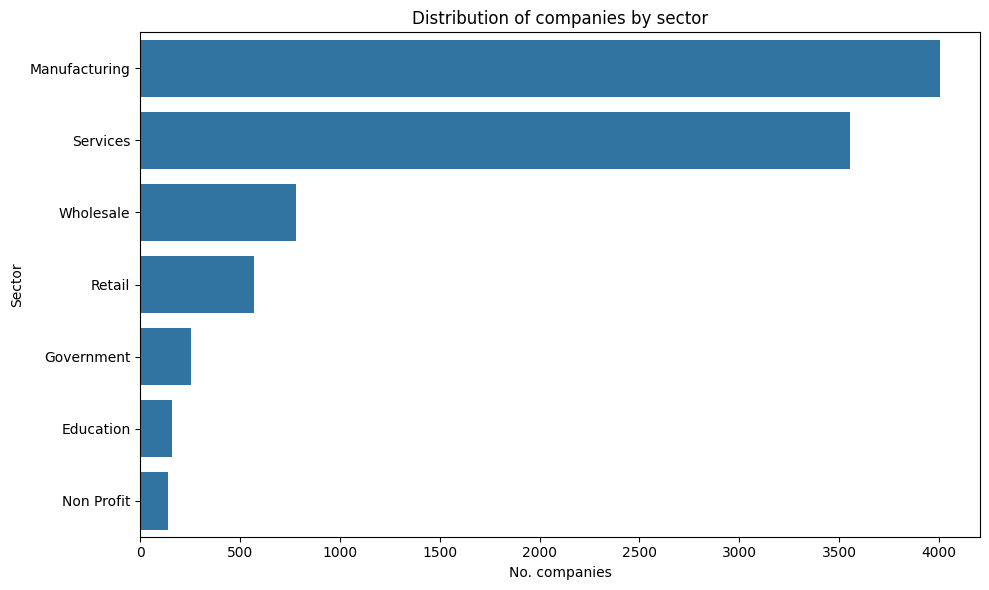

In [7]:
# plot companies by sector
plt.figure(figsize=(10, 6))
sns.countplot(y='sector', data=df_companies, order=df_companies['sector'].value_counts().index)
plt.title('Distribution of companies by sector')
plt.xlabel('No. companies')
plt.ylabel('Sector')
plt.tight_layout()
plt.savefig('sector_distribution.png')

In [8]:
# replace missing values with empty strings
for col in df_companies.columns.tolist():
    df_companies[col].fillna('', inplace=True)

for col in df_manual_labels.columns.tolist():
    df_manual_labels[col].fillna('', inplace=True)

# drop duplicates
df_companies.drop_duplicates(inplace=True)

print('---- Company data overview check ----')
print('---- missing values:\n' + str(df_companies.isnull().sum().to_string()))
print('---- duplicates: ' + str(df_companies.duplicated().sum()))

---- Company data overview check ----
---- missing values:
description      0
business_tags    0
sector           0
category         0
niche            0
---- duplicates: 0


/tmp/ipython-input-181208089.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_companies[col].fillna('', inplace=True)
/tmp/ipython-input-181208089.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [9]:
# combine all columns
df_companies['combined_fields'] = (
    df_companies[['description', 'business_tags', 'sector', 'category', 'niche']]
    .fillna('')
    .agg(' '.join, axis=1) # join all with 1 space in-between
    .str.replace(r"[\[\]'\"]", '', regex=True)  # remove branckets and quotes
    .str.replace(',', ' ', regex=False) # replace commas with spaces
    .str.replace(r'\s+', ' ', regex=True) # replace multiple whitespaces with one only
    .str.strip()
)


df_manual_labels['combined_fields'] = (
    df_manual_labels[['description', 'business_tags', 'sector', 'category', 'niche']]
    .fillna('')
    .agg(' '.join, axis=1) # join all with 1 space in-between
    .str.replace(r"[\[\]'\"]", '', regex=True)  # remove branckets and quotes
    .str.replace(',', ' ', regex=False) # replace commas with spaces
    .str.replace(r'\s+', ' ', regex=True) # replace multiple whitespaces with one only
    .str.strip()
)

## Multi-model classification

In [10]:
total_predicted_companies = pd.DataFrame(index=df_companies.index)
total_predicted_companies['description'] = df_companies['description']

In [11]:
def manual_labels_model_evaluation(df_manual_labels, pred_col, true_col='label'):
    correct = 0
    total = len(df_manual_labels)

    for idx, row in df_manual_labels.iterrows():
        if row[pred_col] == row[true_col]:
            correct += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy, correct, total

## [Frequency-Inverse Document Frequency (TF-IDF) encoding](https://medium.com/@brightcode/classifying-unstructured-text-into-1800-industry-categories-with-llm-and-rag-d5fe4876841f)

In [16]:
print("(1) Running TF-IDF encoding")

# get avg wc for max_features in TfidfVectorizer
avg_word_count = df_companies['combined_fields'].str.split().str.len().mean()
print(f"Average word count: {avg_word_count:.1f}")

# vectorize TFIDF
tfidf_converter = TfidfVectorizer(
    max_features=500,
    min_df=5,
    max_df=0.7
    )
tfidf_X = tfidf_converter.fit_transform(df_companies['combined_fields']).toarray()
tfidf_Y = tfidf_converter.transform(df_taxonomy['label']).toarray()

# best match per company
tfidf_sim_matrix = cosine_similarity(tfidf_X, tfidf_Y)
tfidf_best_match= np.argmax(tfidf_sim_matrix, axis=1)
tfidf_pred_labels = df_taxonomy['label'].iloc[tfidf_best_match].values
tfidf_sim_scores = np.max(tfidf_sim_matrix, axis=1)

# store and save
df_companies['tfidf_pred_label'] = tfidf_pred_labels
df_companies['tfidf_sim_score'] = tfidf_sim_scores
total_predicted_companies['tfidf_pred_label'] = tfidf_pred_labels
total_predicted_companies['tfidf_sim_score'] = tfidf_sim_scores
df_companies.to_csv('classified_companies_with_TFIDF.csv', index=False)
df_companies.to_csv('/content/drive/MyDrive/bia_has_growing_up_to_do_2025_september/veridion_deeptech_engineer/classified_companies_with_TFIDF.csv', index=False)


print("\nSample TF-IDF:")
print(df_companies[['tfidf_pred_label', 'tfidf_sim_score']].head().to_string())

# compare separately to check more easily
print(df_companies[['description']].head().to_string())

# manual labels evaluation
tfidf_X_manual = tfidf_converter.transform(df_manual_labels['combined_fields']).toarray()
tfidf_sim_matrix_manual = cosine_similarity(tfidf_X_manual, tfidf_Y)
tfidf_best_match_manual = np.argmax(tfidf_sim_matrix_manual, axis=1)
df_manual_labels['tfidf_pred_label'] = df_taxonomy['label'].iloc[tfidf_best_match_manual].values
df_manual_labels['tfidf_sim_score'] = np.max(tfidf_sim_matrix_manual, axis=1)
accuracy, correct, total = manual_labels_model_evaluation(df_manual_labels, 'tfidf_pred_label')
print(f"\nTF-IDF accuracy on manual labels: {accuracy:.1%}") # correct / total

# quality check of scores
print(f"\nMin-max score: [{tfidf_sim_scores.min():.3f}, {tfidf_sim_scores.max():.3f}]")
print(f"Mean score: {tfidf_sim_scores.mean():.3f}")
print(f"Median score: {np.median(tfidf_sim_scores):.3f}")

# diversity in predictions
unique_labels = df_companies['tfidf_pred_label'].nunique()
print(f"Unique labels assigned: {unique_labels} / {len(df_taxonomy)} total")

(1) Running TF-IDF encoding
Average word count: 110.1

Sample TF-IDF:
                tfidf_pred_label  tfidf_sim_score
0      Gas Installation Services         0.431768
1      Dairy Production Services         0.159328
2  Community Engagement Services         0.247112
3         Boiler Repair Services         0.424995
4       Water Treatment Services         0.142611
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

## [Sentence Transformers](https://github.com/UKPLab/sentence-transformers)

In [18]:
print("(2) Running Sentence Transformers")

model = SentenceTransformer("all-MiniLM-L6-v2")

st_X = model.encode(df_companies['combined_fields'].tolist(), batch_size=128, convert_to_numpy=True)
st_Y = model.encode(df_taxonomy['label'].tolist(),  batch_size=256, convert_to_numpy=True)

# best match per company
st_sim_matrix = cosine_similarity(st_X, st_Y)
st_best_match= np.argmax(st_sim_matrix, axis=1)
st_pred_labels = df_taxonomy['label'].iloc[st_best_match].values
st_sim_scores = np.max(st_sim_matrix, axis=1)

# store and save
df_companies['st_pred_label'] = st_pred_labels
df_companies['st_sim_score'] = st_sim_scores
total_predicted_companies['st_pred_label'] = st_pred_labels
total_predicted_companies['st_sim_score'] = st_sim_scores
df_companies.to_csv('classified_companies_with_SentenceTransformer.csv', index=False)
df_companies.to_csv('/content/drive/MyDrive/bia_has_growing_up_to_do_2025_september/veridion_deeptech_engineer/classified_companies_with_SentenceTransformer.csv', index=False)

print("Sample SentenceTransformer:")
print(df_companies[['st_pred_label', 'st_sim_score']].head().to_string())

# compare separately to check more easily
print(df_companies[['description']].head().to_string())

# manual labels evaluation
st_X_manual = model.encode(df_manual_labels['combined_fields'].tolist(), batch_size=128, convert_to_numpy=True)
st_sim_matrix_manual = cosine_similarity(st_X_manual, st_Y)
st_best_match_manual = np.argmax(st_sim_matrix_manual, axis=1)
df_manual_labels['st_pred_label'] = df_taxonomy['label'].iloc[st_best_match_manual].values
df_manual_labels['st_sim_score'] = np.max(st_sim_matrix_manual, axis=1)
accuracy, correct, total = manual_labels_model_evaluation(df_manual_labels, 'st_pred_label')
print(f"\nSentence Transformer accuracy on manual labels: {accuracy:.1%}") # correct / total

# quality check of scores
print(f"\nMin-max score: [{st_sim_scores.min():.3f}, {st_sim_scores.max():.3f}]")
print(f"Mean score: {st_sim_scores.mean():.3f}")
print(f"Median score: {np.median(st_sim_scores):.3f}")

# diversity in predictions
unique_labels = df_companies['st_pred_label'].nunique()
print(f"Unique labels assigned: {unique_labels} / {len(df_taxonomy)} total")

(2) Running Sentence Transformers
Sample SentenceTransformer:
                st_pred_label  st_sim_score
0   Gas Installation Services      0.485470
1    Meat Processing Services      0.401668
2  Bakery Production Services      0.540714
3        Pallet Manufacturing      0.336730
4  Ornamental Plant Nurseries      0.234818
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

## Reranker Models

In [19]:
print("(3) Running Cross Encoders")

# model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L6-v2")
model_name = "cross-encoder/mmarco-mMiniLMv2-L12-H384-v1"
model = CrossEncoder(model_name)
final_labels = []
final_scores = []
all_labels = df_taxonomy['label'].tolist()

for company_text in tqdm(df_companies['combined_fields']):
    pairs = [[company_text, label] for label in all_labels]
    scores = model.predict(pairs)
    best_label_idx = np.argmax(scores)
    final_labels.append(all_labels[best_label_idx])
    final_scores.append(scores[best_label_idx])

# store and save
df_companies['ce_pred_label'] = final_labels
df_companies['ce_sim_score'] = final_scores
total_predicted_companies['ce_pred_label'] = final_labels
total_predicted_companies['ce_sim_score'] = final_scores
df_companies.to_csv('classified_companies_with_CrossEncoder.csv', index=False)
df_companies.to_csv('/content/drive/MyDrive/bia_has_growing_up_to_do_2025_september/veridion_deeptech_engineer/classified_companies_with_CrossEncoder.csv', index=False)

print("Sample CrossEncoder:")
print(df_companies[['ce_pred_label', 'ce_sim_score']].head().to_string())

# compare separately to check more easily
print(df_companies[['description']].head().to_string())

# manual labels evaluation
manual_ce_labels = []
manual_ce_scores = []
for company_text in tqdm(df_manual_labels['combined_fields'], desc="Encoding manual labels"):
    pairs = [[company_text, label] for label in all_labels]
    scores = model.predict(pairs)
    best_label_idx = np.argmax(scores)
    manual_ce_labels.append(all_labels[best_label_idx])
    manual_ce_scores.append(scores[best_label_idx])
df_manual_labels['ce_pred_label'] = manual_ce_labels
df_manual_labels['ce_sim_score'] = manual_ce_scores
accuracy, correct, total = manual_labels_model_evaluation(df_manual_labels, 'ce_pred_label')
print(f"\nCross Encoder accuracy on manual labels: {accuracy:.1%}") # correct / total


# quality check of scores
print(f"\nMin-max score: [{np.min(final_scores):.3f}, {np.max(final_scores):.3f}]")
print(f"Mean score: {np.mean(final_scores):.3f}")
print(f"Median score: {np.median(final_scores):.3f}")

# diversity in predictions
unique_labels = df_companies['ce_pred_label'].nunique()
print(f"Unique labels assigned: {unique_labels} / {len(df_taxonomy)} total")

(3) Running Cross Encoders


config.json:   0%|          | 0.00/891 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

100%|██████████| 9492/9492 [1:43:17<00:00,  1.53it/s]


Sample CrossEncoder:
                   ce_pred_label  ce_sim_score
0   Property Management Services     10.856304
1            Veterinary Services      5.620770
2  Community Engagement Services      1.070890
3              Printing Services     -2.501331
4               Welding Services     -0.862203
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Encoding manual labels: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Cross Encoder accuracy on manual labels: 1/10 = 10.0%

Min-max score: [-8.740, 10.957]
Mean score: 4.696
Median score: 4.353
Unique labels assigned: 219 / 220 total


## Sparse Encoder

In [20]:
print("(4) Running Sparse Encoders")

model = SparseEncoder("naver/splade-cocondenser-ensembledistil")
se_X = model.encode(df_companies['combined_fields'].tolist())
se_Y = model.encode(df_taxonomy['label'].tolist())

# best match per company
# se_sim_matrix = cosine_similarity(se_X.to_dense(), se_Y.to_dense())
se_sim_matrix = cosine_similarity(
    se_X.to_dense().cpu().numpy(),
    se_Y.to_dense().cpu().numpy()
)
se_best_match= np.argmax(se_sim_matrix, axis=1)
se_pred_labels = df_taxonomy['label'].iloc[se_best_match].values
se_sim_scores = np.max(se_sim_matrix, axis=1)

# store and save
df_companies['se_pred_label'] = se_pred_labels
df_companies['se_sim_score'] = se_sim_scores
total_predicted_companies['se_pred_label'] = se_pred_labels
total_predicted_companies['se_sim_score'] = se_sim_scores
df_companies.to_csv('classified_companies_with_SparseEncoder.csv', index=False)
df_companies.to_csv('/content/drive/MyDrive/bia_has_growing_up_to_do_2025_september/veridion_deeptech_engineer/classified_companies_with_SparseEncoder.csv', index=False)

print("Sample SparseEncoder:")
print(df_companies[['se_pred_label', 'se_sim_score']].head().to_string())

# compare separately to check more easily
print(df_companies[['description']].head().to_string())

# manual labels evaluation
se_X_manual = model.encode(df_manual_labels['combined_fields'].tolist())
se_sim_matrix_manual = cosine_similarity(
    se_X_manual.to_dense().cpu().numpy(),
    se_Y.to_dense().cpu().numpy()
)
se_best_match_manual = np.argmax(se_sim_matrix_manual, axis=1)
df_manual_labels['se_pred_label'] = df_taxonomy['label'].iloc[se_best_match_manual].values
df_manual_labels['se_sim_score'] = np.max(se_sim_matrix_manual, axis=1)
accuracy, correct, total = manual_labels_model_evaluation(df_manual_labels, 'se_pred_label')
print(f"Sparse Encoder accuracy on manual labels: {accuracy:.1%}") # correct / total

# quality check of scores
print(f"\nMin-max score: [{se_sim_scores.min():.3f}, {se_sim_scores.max():.3f}]")
print(f"Mean score: {se_sim_scores.mean():.3f}")
print(f"Median score: {np.median(se_sim_scores):.3f}")

# diversity in predictions
unique_labels = df_companies['se_pred_label'].nunique()
print(f"Unique labels assigned: {unique_labels} / {len(df_taxonomy)} total")

(4) Running Sparse Encoders


modules.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

Sample SparseEncoder:
                      se_pred_label  se_sim_score
0  Commercial Construction Services      0.266875
1            Pet Food Manufacturing      0.145183
2        Bakery Production Services      0.216958
3                 Painting Services      0.144835
4                   Travel Services      0.060480
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

## Results analysis